In [1]:
#imports
import torch
from torch import nn
import pandas as pd
from torch.autograd import Variable
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
from torch.utils.data import DataLoader
from IPython.utils import io
import warnings
import statistics
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
#read in optical flow rgb images file
images = pd.read_pickle('../data/images.pkl')
images = images.reset_index()
#read labels
labels = None
with open("../speedchallenge/data/train.txt") as f:
    #we drop the first label cause optical flow is two images}
    labels = (list(map(float, f.read().splitlines()))[1:])
labels = np.array(labels)

In [3]:
#model class
class Small(nn.Module):
    
    def __init__(self, batch_size, dim):
        
        super(Small, self).__init__()
        #initialize parameters
        self.batch_size = batch_size
        self.dim = dim
        #representation layer
        self.conv1 = nn.Conv2d(3,12,3,stride=2)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12,32,5,stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,3,stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128,5,stride=1)
        self.bn4 = nn.BatchNorm2d(128)
        #decision layer
        self.fc1 = nn.Linear(dim, 2**10)
        self.fc2 = nn.Linear(2**10, 2**8)
        self.fc3 = nn.Linear(2**8, 2**6)
        self.fc4 = nn.Linear(2**6, 2**0)
        #droput layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)
    
    def forward(self, x):
        
        #apply convolutions
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)),2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)),2))
        x = F.relu(F.max_pool2d(self.bn3(self.conv3(x)),2))
        x = F.relu(F.max_pool2d(self.bn4(self.conv4(x)),2))
        #apply decision layers
        x = x.reshape(self.batch_size, -1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = F.relu(self.fc3(x))
        x = self.dropout4(x)
        x = self.fc4(x)
        return x

In [4]:
batch_size = 64
dim = 4480
n_train_examples = 10000
test_size = 0.1
n_epochs = 100
lr=1e-2

#initialize model
model = Small(batch_size=batch_size, dim=dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = nn.MSELoss()

#use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#create prediction model
model.to(device)

Small(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4480, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (dropout4):

In [5]:
#function to create data loader
def get_loader(n, batch_size):
    #sample n images above sequence length index
    sample_images = images.sample(n).index
    vectors = list(images.iloc[idx].Image.reshape(480,640,3).permute(2,0,1).cpu().numpy() for idx in tqdm(sample_images))
    targets = list(labels[idx] for idx in tqdm(sample_images))
    return vectors, targets

In [6]:
#data loader classes
class MyTrainDataloader(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(zip(torch.tensor(x_train),torch.tensor(y_train)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], self.data[idx][1] 
    
class MyValDataLoader(torch.utils.data.Dataset):
    def __init__(self):
        self.data = list(zip(torch.tensor(x_val),torch.tensor(y_val)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], self.data[idx][1] 

In [7]:
#create train and test data loaders
dataset_x, dataset_y = get_loader(n_train_examples, batch_size)
x_train, x_val, y_train, y_val = train_test_split(dataset_x, dataset_y, test_size=test_size)

train_data = MyTrainDataloader()
train_loader = torch.utils.data.DataLoader(train_data,
                                           shuffle=True,
                                           num_workers=2,
                                           batch_size=batch_size,
                                           drop_last=True)

val_data = MyValDataLoader()
val_loader = torch.utils.data.DataLoader(val_data,
                                           shuffle=True,
                                           num_workers=2,
                                           batch_size=batch_size,
                                           drop_last=True)

100%|██████████| 10000/10000 [00:00<00:00, 1997858.44it/s]


In [8]:
%%capture
#for switching model between train and eval without cell output
def train():
    with io.capture_output() as captured:
        model.train()

def test():
    with io.capture_output() as captured:
        model.eval()

In [9]:
warnings.filterwarnings("ignore")

#track loss values
train_losses = []
val_losses = []

#begin training
for epoch in range(1, n_epochs + 1):
    
    #train
    train()
    train_loss = 0
    for batch in train_loader:
        x, y = batch[0], batch[1]
        optimizer.zero_grad()
        pred = model(torch.tensor(x).float().cuda())
        loss = criterion(pred.flatten(), torch.tensor(y).float().cuda())
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    scheduler.step()
    
    #validate
    if epoch%1 == 0:
        test()
        val_loss = 0
        for batch in val_loader:
            x, y = batch[0], batch[1]
            pred = model(torch.tensor(x).float().cuda())
            loss = criterion(pred.flatten(), torch.tensor(y).float().cuda())
            val_loss+=loss.item()
        
        #print progress
        print('Epoch: {}/{}.............'.format(epoch, n_epochs))
        print("Train MSE: {:.4f}".format(train_loss/len(train_loader)))
        print("Val MSE: {:.4f}".format(val_loss/len(val_loader)), "\n")
        
        #track loss
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

Epoch: 1/100.............
Train MSE: 253.0505
Val MSE: 44.9664 

Epoch: 2/100.............
Train MSE: 30.0689
Val MSE: 48.1136 

Epoch: 3/100.............
Train MSE: 25.1335
Val MSE: 33.4297 

Epoch: 4/100.............
Train MSE: 23.8789
Val MSE: 19.0396 

Epoch: 5/100.............
Train MSE: 20.9936
Val MSE: 34.7993 

Epoch: 6/100.............
Train MSE: 20.8785
Val MSE: 80.3419 

Epoch: 7/100.............
Train MSE: 19.5906
Val MSE: 83.0739 

Epoch: 8/100.............
Train MSE: 18.0169
Val MSE: 31.8839 

Epoch: 9/100.............
Train MSE: 19.7333
Val MSE: 36.3981 

Epoch: 10/100.............
Train MSE: 16.7554
Val MSE: 19.3661 

Epoch: 11/100.............
Train MSE: 17.7076
Val MSE: 59.3676 

Epoch: 12/100.............
Train MSE: 15.5778
Val MSE: 10.9469 

Epoch: 13/100.............
Train MSE: 16.6270
Val MSE: 34.0757 

Epoch: 14/100.............
Train MSE: 14.5274
Val MSE: 19.6385 

Epoch: 15/100.............
Train MSE: 14.6532
Val MSE: 16.6367 

Epoch: 16/100.............
Train 

In [10]:
pd.DataFrame(list(zip(train_losses,val_losses)), columns=['Train MSE', 'Val MSE']).to_csv('../charts/medium.csv')

In [11]:
cdf = pd.read_csv('../charts/medium.csv')

In [12]:
import matplotlib.pyplot as plt

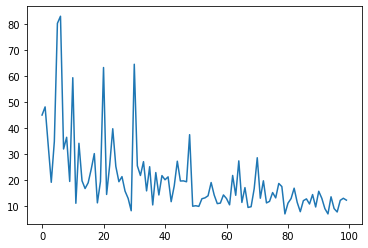

In [14]:
plt.plot(cdf['Val MSE'])